## CIFAR-10 Data Preprocessing for Hopfield Networks and Phase Space Learning

### Step 1: Install and Import Required Libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# import models
from hopfield_PSL import HopfieldPSL

### Step 2: Load the CIFAR-10 Dataset

In [3]:
# defining a transform for converting images to grayscale and tensors
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
color_trainset = datasets.CIFAR10(root='./data', train=True, download=True)

print(f'Training set size: {len(train_dataset)}')

100%|██████████| 170498071/170498071 [00:05<00:00, 32330281.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000


### Step 3: Binarize the Images to -1/+1

In [4]:
# convert images to numpy arrays
train_images = torch.stack([img for img,_ in train_dataset]).numpy()

# binarize the images
train_images = np.where(train_images > 0.5, 1, -1)

# verify the range of values
print(f'Unique pixel values after binarization: {np.unique(train_images)}')

Unique pixel values after binarization: [-1  1]


### Step 4: Reshape Images into 1024-bit Vectors

In [5]:
train_images = train_images.reshape(len(train_images), -1)

### Step 6: Visualize Some Binarized Images

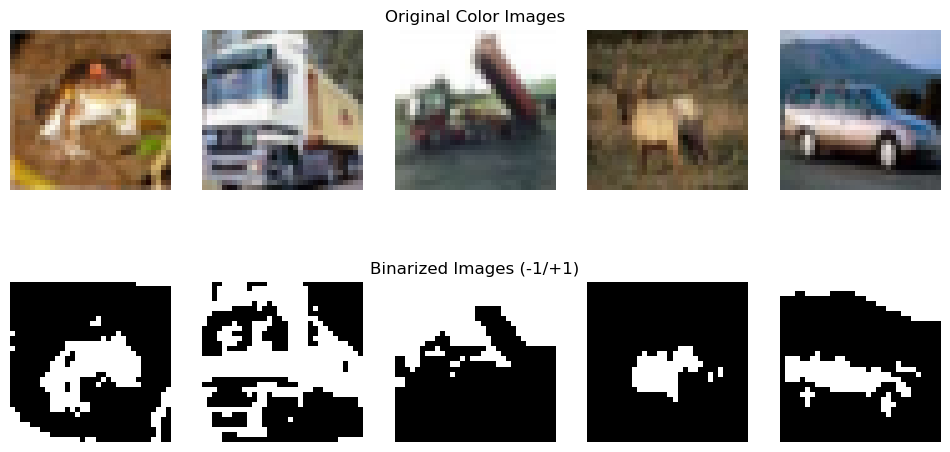

In [6]:
num_images = 5
fig, axes = plt.subplots(2,num_images,figsize=(12,6))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')

plt.show()

### Step 7: Generate a Corrupted Subset of Training Images

In [7]:
def corrupt_images(images, corruption_type="mask ", corruption_fraction=0.25):
    """
    Corrupt images by either masking pixels or flipping them

    Args:
        images (numpy array): binarized images to corrupt
        corruption_type (str): "mask" to set pixels to 0, "flip" to invert pixels
        corruption_fraction (float): Fraction of pixels to corrupt

    Returns:
        numpy array: Corrupted images
    """
    corrupted_images = images.copy()
    num_pixels = images.shape[1]
    num_corrupt = int(corruption_fraction * num_pixels)

    for img in corrupted_images:
        corrupt_indices = np.random.choice(num_pixels, num_corrupt, replace=False)

        if corruption_type == 'mask':
            img[corrupt_indices] = 0
        elif corruption_type == 'flip':
            img[corrupt_indices] *= -1
    return corrupted_images

In [8]:
# create corrupted images to use as test set
masked_images = corrupt_images(train_images, corruption_type='mask', corruption_fraction=0.25)
flipped_images = corrupt_images(train_images, corruption_type='flip', corruption_fraction=0.25)

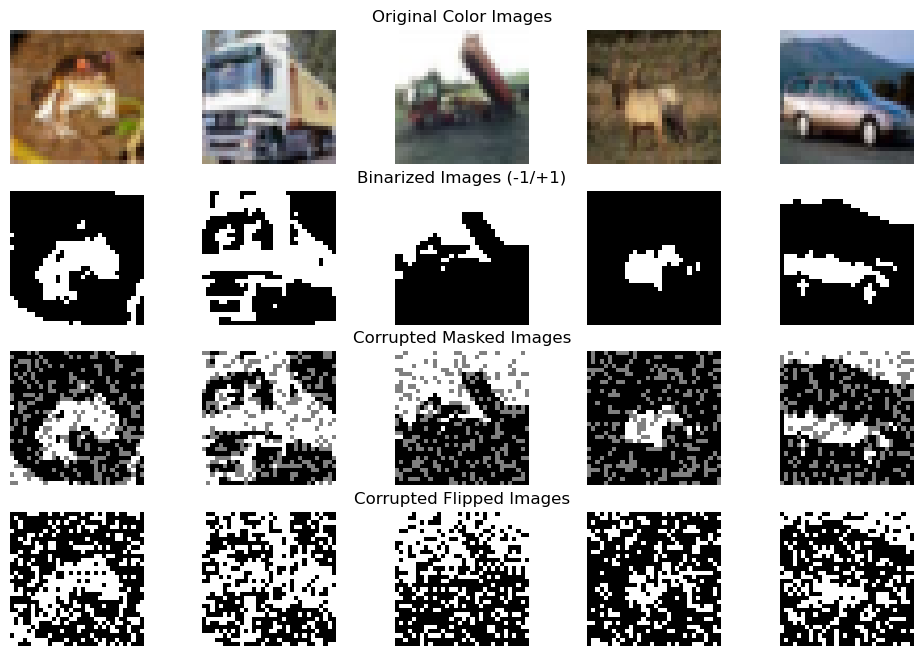

In [9]:
# Visualize some corrupted images

num_images = 5
fig, axes = plt.subplots(4,num_images,figsize=(12,8))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

    # Plot corrupted masked images
    axes[2,i].imshow(masked_images[i].reshape(32,32), cmap='gray')
    axes[2,i].axis('off')

    # Plot corrupted flipped images
    axes[3,i].imshow(flipped_images[i].reshape(32,32), cmap='gray')
    axes[3,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')
axes[2,num_images//2].set_title('Corrupted Masked Images', fontsize=12, loc='center')
axes[3,num_images//2].set_title('Corrupted Flipped Images', fontsize=12, loc='center')


plt.show()

### Step 8: Save the Preprocessed Datasets

In [10]:
# Create 'data/binarized' directory if it doesn't exist
if not os.path.isdir('data/binarized'):
    os.mkdir('data/binarized')

np.save("data/binarized/train_images.npy", train_images)
np.save("data/binarized/masked_images.npy", masked_images)
np.save("data/binarized/flipped_images.npy", flipped_images)


In [11]:
len(train_images)

50000

### Training

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import hopfield_PSL
import importlib
# import models

# from hopfield_baseline import HopfieldRNN
# from storkey import HopfieldRNNStorkey

# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [16]:
importlib.reload(hopfield_PSL)

num_neurons = 1024
num_patterns = 200
epochs = 30
lr = 2e-4
model = hopfield_PSL.HopfieldPSL(5)

optimizer = optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.MSELoss()

idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)
original = [stored_images[i] for i in idxs]
corrupted = [flipped_images[i] for i in idxs]
targets = [tensor * 0.9 for tensor in original]

In [17]:
model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for i in range(len(original)):
        optimizer.zero_grad()          # Clear gradients
        output = model(original[i])          # Forward pass

        loss = criterion(output, targets[i])  # Compute reconstruction loss
        
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Update weights
        
        total_loss += loss.item()
    avg_loss = total_loss / len(original)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch [5/30], Loss: 0.260377
Epoch [10/30], Loss: 0.157313
Epoch [15/30], Loss: 0.089376
Epoch [20/30], Loss: 0.048605
Epoch [25/30], Loss: 0.024736
Epoch [30/30], Loss: 0.018490


In [18]:
# retrieved = [torch.sign(model(model(model(model(model(img))))).detach()).numpy() for img in corrupted]
retrieved = [torch.sign(model(img).detach()).numpy() for img in corrupted]

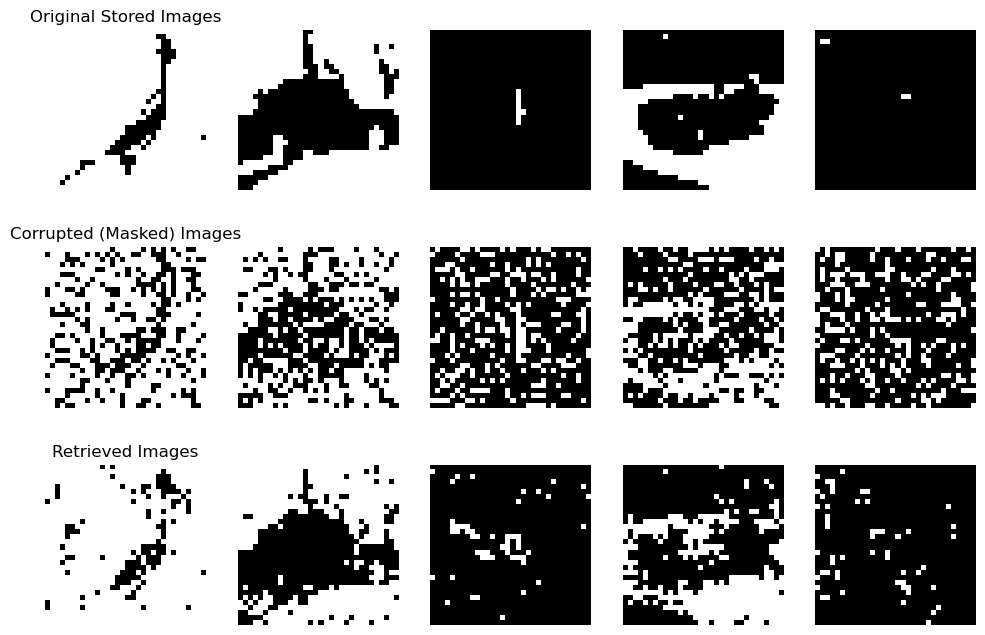

In [19]:
import matplotlib.pyplot as plt

def plot_comparisons(original, corrupted, retrieved, title_corrupted, title_retrieved, num_samples=5):

    fig, axes = plt.subplots(3, num_samples, figsize=(12, 8))

    for i in range(num_samples):
        # Original stored image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Corrupted image
        axes[1, i].imshow(corrupted[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Retrieved image
        axes[2, i].imshow(retrieved[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

    # Add row titles
    axes[0, 0].set_title("Original Stored Images", fontsize=12, loc='center')
    axes[1, 0].set_title(title_corrupted, fontsize=12, loc='center')
    axes[2, 0].set_title(title_retrieved, fontsize=12, loc='center')
    plt.savefig("psl_k.png")
    plt.show()

# Plot results for masked images
plot_comparisons(original, corrupted, retrieved, "Corrupted (Masked) Images", "Retrieved Images")


# Grayscale PSL

In [20]:
from hopfield_PSL import HopfieldPSL_Gray

In [21]:
# defining a transform for converting images to grayscale and tensors
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [23]:
# Make Grayscale Images
# defining a transform for converting images to grayscale and tensors
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
color_trainset = datasets.CIFAR10(root='./data', train=True, download=True)

print(f'Training set size: {len(train_dataset)}')

# Create directory to save grayscale images
save_dir = 'data/grayscale_images'
os.makedirs(save_dir, exist_ok=True)

# Save grayscale images as NumPy arrays
grayscale_images = [img.numpy() for img, _ in train_dataset]
grayscale_images_np = np.array(grayscale_images)
np.save(os.path.join(save_dir, "train_images.npy"), grayscale_images_np)

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000


In [27]:
def corrupt_images(images, corruption_type="mask ", corruption_fraction=0.25):
    """
    Corrupt images by either masking pixels or flipping them

    Args:
        images (numpy array): binarized images to corrupt
        corruption_type (str): "mask" to set pixels to 0, "flip" to invert pixels
        corruption_fraction (float): Fraction of pixels to corrupt

    Returns:
        numpy array: Corrupted images
    """
    if isinstance(images, torch.Tensor):
        images = images.numpy()
        
    corrupted_images = images.copy()
    num_pixels = images.shape[1]
    num_corrupt = int(corruption_fraction * num_pixels)

    for img in corrupted_images:
        corrupt_indices = np.random.choice(num_pixels, num_corrupt, replace=False)

        if corruption_type == 'mask':
            img[corrupt_indices] = 0
        elif corruption_type == 'flip':
            img[corrupt_indices] *= -1
    return corrupted_images

In [28]:
# create corrupted images to use as test set
masked_images = corrupt_images(encoded_images, corruption_type='mask', corruption_fraction=0.25)
flipped_images = corrupt_images(encoded_images, corruption_type='flip', corruption_fraction=0.25)

In [30]:
# Save corrupted data
np.save("data/grayscale_images/masked_images.npy", masked_images)
np.save("data/grayscale_images/flipped_images.npy", flipped_images)

In [24]:
def encode(img):
    """
    Encodes a grayscale image (0-255) into a binary representation (-1,1).
    
    Args:
        img (torch.Tensor): Grayscale image of shape (H, W), values in [0, 255].
    
    Returns:
        torch.Tensor: Encoded binary vector of shape (H*W*8,), values in {-1,1}.
    """
    img = img * 255 if img.max() <= 1 else img
    flat = img.flatten()
    flat_np = flat.numpy().astype(np.uint8)
    bits = np.unpackbits(flat_np.reshape(-1, 1), axis=1)
    encoded = 2 * bits - 1  # Convert {0,1} -> {-1,1}
    encoded_flat = encoded.flatten()
    return torch.tensor(encoded_flat, dtype=torch.int8)

def decode(encoded):
    """
    Decodes a binary vector (-1,1) back into a grayscale image (0-255).
    
    Args:
        encoded (torch.Tensor): Encoded binary vector of shape (H*W*8,), values in {-1,1}.
    
    Returns:
        torch.Tensor: Decoded grayscale image of shape (H, W), values in [0, 255].
    """
    if isinstance(encoded, torch.Tensor):
        encoded_reshaped = encoded.reshape(-1, 8)
        bits = ((encoded_reshaped + 1) // 2).numpy().astype(np.uint8)  # Convert {-1,1} -> {0,1}
    else:  # Assuming encoded is a numpy array
        encoded_reshaped = encoded.reshape(-1, 8)
        bits = ((encoded_reshaped + 1) // 2).astype(np.uint8)  # Convert {-1,1} -> {0,1}
    
    pixels = np.packbits(bits, axis=1)
    pixels = pixels.squeeze(1)
    
    img = torch.from_numpy(pixels).reshape(32, 32)  # Assuming a 32x32 image
    return img


# Load saved grayscale images
stored_images_np = np.load("data/grayscale_images/train_images.npy")
stored_images = torch.tensor(stored_images_np, dtype=torch.float32)

# Encode grayscale images into binary representation (-1, 1)
encoded_images = torch.stack([encode(img) for img in stored_images])
encoded_images = torch.tensor(encoded_images, dtype=torch.float32)

/tmp/ipykernel_254/3079772564.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_images = torch.tensor(encoded_images, dtype=torch.float32)


In [31]:
# Reload for training
stored_images = torch.tensor(np.load("data/grayscale_images/train_images.npy"), dtype=torch.float32)
masked_images = torch.tensor(np.load("data/grayscale_images/masked_images.npy"), dtype=torch.float32)
flipped_images = torch.tensor(np.load("data/grayscale_images/flipped_images.npy"), dtype=torch.float32)

In [32]:
num_patterns = 300

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = encoded_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]
baseline_targets = [tensor * 0.9 for tensor in baseline_original]

In [33]:
baseline_targets[0]

tensor([ 0.9000, -0.9000, -0.9000,  ..., -0.9000, -0.9000,  0.9000])

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_original = baseline_original.to(device)
baseline_targets = [tensor.to(device) for tensor in baseline_targets]

epochs = 50
lr = 3e-5
model = hopfield_PSL.HopfieldPSL_Gray(10).to(device)

optimizer = optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.MSELoss()

model.train()

HopfieldPSL_Gray(
  (skip): Linear(in_features=8192, out_features=8192, bias=True)
  (down): Linear(in_features=8192, out_features=100, bias=True)
  (up): Linear(in_features=100, out_features=8192, bias=True)
  (activation): Tanh()
)

In [35]:
device

device(type='cuda')

In [37]:
# Ont-time Usage
epochs = 50

In [38]:
for epoch in range(epochs):
    total_loss = 0.0
    for i in range(len(baseline_original)):
        optimizer.zero_grad()          # Clear gradients
        output = model(baseline_original[i])          # Forward pass

        loss = criterion(output, baseline_targets[i])  # Compute reconstruction loss
        
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Update weights
        
        total_loss += loss.item()
    avg_loss = total_loss / len(baseline_original)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch [5/50], Loss: 0.701004
Epoch [10/50], Loss: 0.545649
Epoch [15/50], Loss: 0.408561
Epoch [20/50], Loss: 0.299446
Epoch [25/50], Loss: 0.204669
Epoch [30/50], Loss: 0.128156
Epoch [35/50], Loss: 0.070329
Epoch [40/50], Loss: 0.040212
Epoch [45/50], Loss: 0.027344
Epoch [50/50], Loss: 0.022541


In [39]:
model.to("cpu")
baseline_original = baseline_original.cpu()
baseline_targets = [tensor.cpu() for tensor in baseline_targets]

In [40]:
retrieved = [torch.sign(model(img).detach()).numpy() for img in baseline_flipped]
baseline_retrieved = [decode(img) for img in retrieved]
original = [decode(img) for img in baseline_original]
flipped = [decode(img) for img in baseline_flipped]

In [41]:
len(baseline_flipped[0])

8192

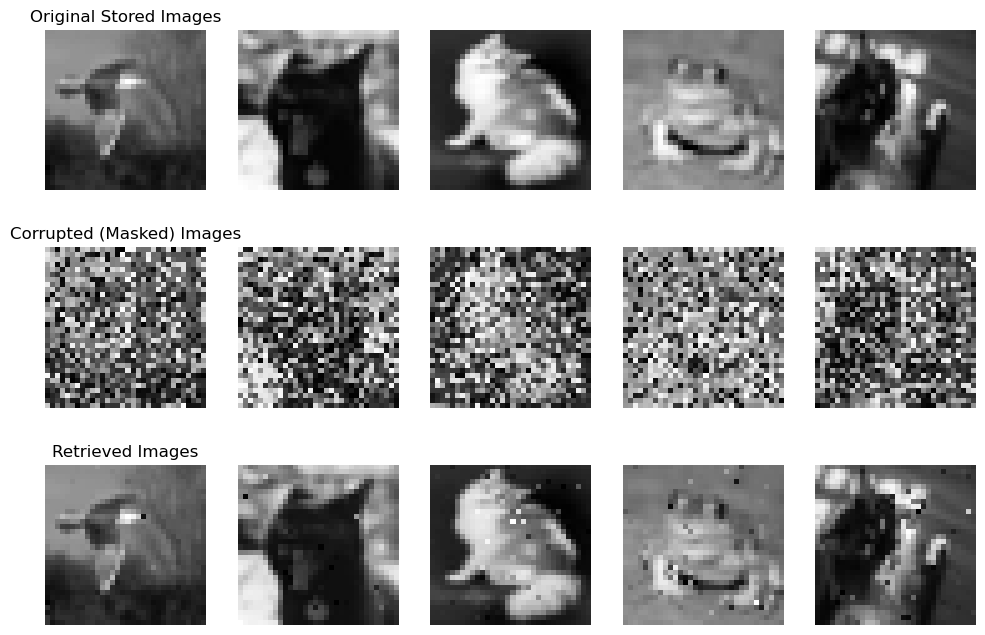

In [42]:
plot_comparisons(original, flipped, baseline_retrieved, "Corrupted (Masked) Images", "Retrieved Images")